# Feature Selection

In this practical, you will become familiarized with some basic feature selection methods implemented in scikit-learn. Consider the prostate dataset that is attached to this practical. You are asked to:

1. Estimate the performance of the nearest neighbor classifier on this dataset using 10-fold cross validation when all the features are used for prediction. The number of neighbors should be chosen using an inner cross-validation procedure. You can use 5-fold cross validation for this.

2. Estimate the performance of the nearest neighbor classifier on the same dataset when using a feature selection technique based on the F-score (ANOVA) that picks up the 10 most relevant features. Use the same cross-validation methods as in the previous step.

3. Repeat the previous experiment but when a random forest is used to pick up the 10 most relevant features. Use an initial filtering method based on the F-score to keep only the 20% most promising features.

4. What feature selection method performs best? Can you explain why?

Now we will address the problem of analyzing the trade-off between interpretability and prediction accuracy. For this, you are asked to:

1. Estimate the performance of the nearest neighbor classifier with K=3 as a function of the features used for prediction. Use a 10-times 10-fold cross-validation method and plot the results obtained. That is prediction error vs. the number of features used for prediction. Use the F-score for feature selection. Report results from 1 feature to 200 features. Not all features need to be explored. Use a higher resolution when you are closer to 1 feature.

2. Repeat that process when the feature selection is done externally to the cross-validation loop using all the available data. Include these results in the previous plot.
3. Are the two estimates obtained similar? What are their differences? If they are different try to explain why this is the case.

4. By taking a look at these results, what is the optimal number of features to use in this dataset?

5. Given the results obtained in this part of the practical, you are asked to indicate which particular features should be used for prediction on this dataset. Include a list with them. Take a look at the documentation of SelectKBest from scikit-learn to understand how to do this. Use all available data to provide such a list of features. 

In [17]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns; sns.set()
import scipy.stats as stats
import scipy as sp
from scipy import linalg
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, classification_report, precision_score

## Question 1

Estimate the performance of the nearest neighbor classifier on this dataset using 10-fold cross validation when all the features are used for prediction. The number of neighbors should be chosen using an inner cross-validation procedure. You can use 5-fold cross validation for this.

### Response 1

We obtain a mean accuracy of $0.74$ with std $0.15$

In [3]:
# Load data
data = pd.read_csv('prostate.csv', header = 0)
X = data.values[ :, 0:-1].astype(np.float)
y = (data.values[ :, -1] == 1).astype(np.int)

In [4]:
X_train, X_test, y_train, y_test = train_test_split( \
    X, y, test_size=0.3, random_state=1)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Check
print(np.var(X_train[:,0]))
print(np.var(X_train[:,1]))
print(np.var(X_train_scaled[:,0]))
print(np.var(X_train_scaled[:,1]))

0.019316280607701256
0.021687892317377073
0.9999999999999994
1.0


In [5]:
pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])
N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
param_grid = { 'knn__n_neighbors': N_neighbors }
skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)
gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
    scoring=make_scorer(accuracy_score))
result = gridcv.fit(X_train_scaled, y_train)
accuracies = gridcv.cv_results_['mean_test_score']
std_accuracies = gridcv.cv_results_['std_test_score']
test_accuracies = np.ones(len(N_neighbors))

for i in range(len(N_neighbors)):
    knn = KNeighborsClassifier(n_neighbors = N_neighbors[ i ])
    knn.fit(X_train_scaled, y_train)
    test_accuracies[ i ] = accuracy_score(knn.predict(X_test_scaled), y_test)

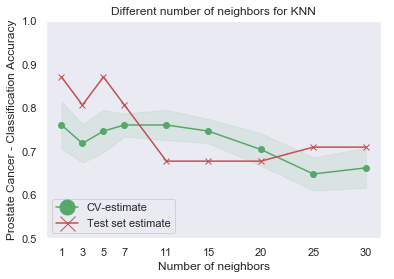

Selected optimal number of neighbors 1


In [6]:
plt.figure()
line1, = plt.plot(N_neighbors, accuracies, 'o-', color="g")
line2, = plt.plot(N_neighbors, test_accuracies, 'x-', color="r")
plt.fill_between(N_neighbors, accuracies - std_accuracies / np.sqrt(10), \
    accuracies + std_accuracies / np.sqrt(10), alpha=0.1, color="g")
plt.grid()
plt.title("Different number of neighbors for KNN")
plt.xlabel('Number of neighbors')
plt.xticks(np.array(N_neighbors))
plt.ylabel('Prostate Cancer - Classification Accuracy')
plt.ylim((0.5, 1.0))
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                          markersize=15, label='CV-estimate'), \
                mlines.Line2D([], [], color='r', marker='x', \
                          markersize=15, label='Test set estimate')]
plt.legend(handles=legend_handles, loc = 3)
plt.show()

N_neighbors_selected = N_neighbors[np.argmax(accuracies)]
print("Selected optimal number of neighbors", N_neighbors_selected)

In [8]:
# Training
knn = KNeighborsClassifier(n_neighbors = N_neighbors_selected)

In [10]:
# Evaluating performance for all features
(_, n_features) = X.shape
print("Number of features", n_features)
n_splits = 10
random_state = 1
rkf = KFold(n_splits=n_splits, random_state=random_state)
split = 0
knn_scores = np.zeros(n_splits)
for train_index, test_index in rkf.split(X, y):
    print("Partition", split)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardization
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Training & scoring
    knn.fit(X_train, y_train)
    knn_scores[split] = knn.score(X_test, y_test)
    split += 1
print()
print("Accuracy scores", knn_scores)
print()
print("Mean", knn_scores.mean(), "Std", knn_scores.std())

Number of features 12625
Partition 0
Partition 1
Partition 2
Partition 3
Partition 4
Partition 5
Partition 6
Partition 7
Partition 8
Partition 9

Accuracy scores [0.54545455 0.81818182 0.6        1.         0.8        0.5
 0.8        0.7        0.7        0.9       ]

Mean 0.7363636363636364 Std 0.1498759817894628


## Question 2

Estimate the performance of the nearest neighbor classifier on the same dataset when using a feature selection technique based on the F-score (ANOVA) that picks up the 10 most relevant features. Use the same cross-validation methods as in the previous step.

### Response 2

We obtain a mean accuracy score of $0.94$ with std mean error $0.02$

In [55]:
n_features = 10
print("Number of features", n_features)
n_splits = 10
random_state = 2
np.random.seed(0)
rkf = KFold(n_splits=n_splits, random_state=random_state)
split = 0
knn_scores = np.zeros(n_splits)
knn_errors = np.zeros(n_splits)
knn_scores_train = np.zeros(n_splits)
for train_index, test_index in rkf.split(X, y):
    print("Partition", split)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardization
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Filtering
    filtering = SelectKBest(f_classif, k = n_features)
    filtering.fit(X_train, y_train)
    X_train_filtered = filtering.transform(X_train)
    X_test_filtered = filtering.transform(X_test)
    
    # Training & scoring
    knn.fit(X_train_filtered, y_train)
    knn_scores[split] = knn.score(X_test_filtered, y_test)
    knn_scores_train[split] = knn.score(X_train_filtered, y_train)
    knn_errors[split] = 1.0 - np.mean(knn.predict(X_test_filtered) == y_test)
    split += 1
print()
print("Accuracy scores", knn_scores)
print()
print("Mean", knn_scores.mean(), "std mean error",(np.std(knn_scores) / np.sqrt(len(knn_scores))))
print()
print("Errors", knn_errors)
print()
print("Mean", knn_errors.mean(), "std mean error", (np.std(knn_errors) / np.sqrt(len(knn_errors))))
print()
print("Accuracy scores train", knn_scores_train)
print()
print("Mean", knn_scores_train.mean(), "std mean error",(np.std(knn_scores_train) / np.sqrt(len(knn_scores_train))))
print()

Number of features 10
Partition 0
Partition 1
Partition 2
Partition 3
Partition 4
Partition 5
Partition 6
Partition 7
Partition 8
Partition 9

Accuracy scores [1.         0.90909091 1.         0.8        1.         0.9
 0.9        1.         0.9        1.        ]

Mean 0.9409090909090908 std mean error 0.02081996816472506

Errors [0.         0.09090909 0.         0.2        0.         0.1
 0.1        0.         0.1        0.        ]

Mean 0.05909090909090908 std mean error 0.02081996816472506

Accuracy scores train [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Mean 1.0 std mean error 0.0



## Question 3

Repeat the previous experiment but when a random forest is used to pick up the 10 most relevant features. Use an initial filtering method based on the F-score to keep only the 20% most promising features.


### Response 3

We obtain a mean accuracy score of $0.92$ with std mean error $0.02$

In [56]:
n_features = 10
print("Number of features", n_features)
n_splits = 10
random_state = 2
np.random.seed(0)
rkf = KFold(n_splits=n_splits, random_state=random_state)
split = 0
knn_scores = np.zeros(n_splits)
knn_errors = np.zeros(n_splits)
knn_scores_train = np.zeros(n_splits)
rf_selection =  SelectFromModel(RandomForestClassifier(n_estimators = 2000,\
                                                       random_state = random_state), threshold = 0.0)
for train_index, test_index in rkf.split(X, y):
    print("Partition", split)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardization
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Filtering pass 1 via F-score, only 20%
    _, inner_features = X_train.shape
    features_to_retain = int(20*inner_features/100)
    filtering = SelectKBest(f_classif, k = features_to_retain)
    filtering.fit(X_train, y_train)
    X_train_filtered_F = filtering.transform(X_train)
    X_test_filtered_F = filtering.transform(X_test)
    _, n_features_reduction_F = X_train_filtered_F.shape
    print("Features reduced to (first pass)", n_features_reduction_F)
    
    # Filtering random forest
    rf_selection.fit(X_train_filtered_F, y_train)
    rf_selection.threshold = -1.0 * np.sort(-1.0 * rf_selection.estimator_.feature_importances_)[n_features-1]
    X_train_filtered_F_R = rf_selection.transform(X_train_filtered_F)
    X_test_filtered_F_R = rf_selection.transform(X_test_filtered_F)
    _, n_features_reduction = X_train_filtered_F_R.shape
    print("Features reduced to (second pass)", n_features_reduction)
    
    # Training & scoring
    knn.fit(X_train_filtered_F_R, y_train)
    knn_scores[split] = knn.score(X_test_filtered_F_R, y_test)
    knn_errors[split] = 1.0 - np.mean(knn.predict(X_test_filtered_F_R) == y_test)
    knn_scores_train[split] = knn.score(X_train_filtered_F_R, y_train)
    split += 1
print()
print("Accuracy scores", knn_scores)
print()
print("Mean", knn_scores.mean(), "std mean error",(np.std(knn_scores) / np.sqrt(len(knn_scores))))
print()
print("Errors", knn_errors)
print()
print("Mean", knn_errors.mean(), "std mean error", (np.std(knn_errors) / np.sqrt(len(knn_errors))))
print()
print("Accuracy scores train", knn_scores_train)
print()
print("Mean", knn_scores_train.mean(), "std mean error",(np.std(knn_scores_train) / np.sqrt(len(knn_scores_train))))
print()

Number of features 10
Partition 0
Features reduced to (first pass) 2525
Features reduced to (second pass) 10
Partition 1
Features reduced to (first pass) 2525
Features reduced to (second pass) 10
Partition 2
Features reduced to (first pass) 2525
Features reduced to (second pass) 10
Partition 3
Features reduced to (first pass) 2525
Features reduced to (second pass) 10
Partition 4
Features reduced to (first pass) 2525
Features reduced to (second pass) 10
Partition 5
Features reduced to (first pass) 2525
Features reduced to (second pass) 10
Partition 6
Features reduced to (first pass) 2525
Features reduced to (second pass) 10
Partition 7
Features reduced to (first pass) 2525
Features reduced to (second pass) 10
Partition 8
Features reduced to (first pass) 2525
Features reduced to (second pass) 10
Partition 9
Features reduced to (first pass) 2525
Features reduced to (second pass) 10

Accuracy scores [0.90909091 0.90909091 1.         0.8        1.         0.9
 0.9        1.         0.9     

## Question 4
What feature selection method performs best? Can you explain why?

### Response 4

ANOVA performs marginally better than Random Forest, with overlapping confidence intervals:

- Anova $0.94 \pm 0.02$.
- Random Forest $0.92 \pm 0.02$.

Decision trees are prone to be more sticky to the data, because of his very hard dependences of initial selection nodes, because it chooses the best result at a given step, but does not ensure that this is the optimal decision of the whole route to the leaf node. Random forests mitigate this problem but the algorithm needs enough features in order to make more effective the randomization.

In fact, if we rise the number of selected features to $20$, the numbers are just the opposite:

- Anova $0.92 \pm 0.02$.
- Random Forest $0.94 \pm 0.02$.


# Outputs

In [57]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx feature_selection_v2.ipynb 1> /dev/null
pdflatex -shell-escape feature_selection_v2 1> /dev/null
jupyter nbconvert --to html_with_toclenvs feature_selection_v2.ipynb 1> /dev/null

[NbConvertApp] Converting notebook feature_selection_v2.ipynb to latex
[NbConvertApp] Support files will be in feature_selection_v2_files/
[NbConvertApp] Making directory feature_selection_v2_files
[NbConvertApp] Writing 41604 bytes to feature_selection_v2.tex
[NbConvertApp] Converting notebook feature_selection_v2.ipynb to html_with_toclenvs
[NbConvertApp] Writing 371529 bytes to feature_selection_v2.html
